**Introduction to Deep Learning Final Project**

Problem Description:

For my final project, I wanted to explore GAN models some more and learn how to implament different methods of producing images through deep learning mechanisms. For this project, I am trying to create a model that will accurately classify images of Dogs.

With all this said, one of my main hopes and goals to takeaway from this project is to gain a better understanding of how GANs work and where I can utalize them in my daily work. I currently work as a workforce planning analyst. I'm wondering if it would be possible to train a model to detect how well one of our charts/graphs is doing and use that info to predict the future state. Long winded, but I'm really excited to continue to learn about GAN models and dive deeper into this project. 

# Import Libraries

In [3]:
#Import all packages and libraries needed for analysis

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
from torch import autograd
import torch.nn.functional as F
from torch.nn import Parameter
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset,DataLoader,Subset
from PIL import Image,ImageOps,ImageEnhance

import cv2
import albumentations as A
from albumentations.pytorch import ToTensor

import glob
import xml.etree.ElementTree as ET #for parsing XML
import shutil
from tqdm import tqdm
import time
import random

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Annotation.zip', 'all-dogs.zip']


In [4]:
!unzip ../input/Annotation.zip
!unzip ../input/all-dogs.zip

Archive:  ../input/Annotation.zip
   creating: Annotation/
   creating: Annotation/n02097658-silky_terrier/
  inflating: Annotation/n02097658-silky_terrier/n02097658_98  
   creating: __MACOSX/
   creating: __MACOSX/Annotation/
   creating: __MACOSX/Annotation/n02097658-silky_terrier/
  inflating: __MACOSX/Annotation/n02097658-silky_terrier/._n02097658_98  
  inflating: Annotation/n02097658-silky_terrier/n02097658_2535  
  inflating: __MACOSX/Annotation/n02097658-silky_terrier/._n02097658_2535  
  inflating: Annotation/n02097658-silky_terrier/n02097658_271  
  inflating: __MACOSX/Annotation/n02097658-silky_terrier/._n02097658_271  
  inflating: Annotation/n02097658-silky_terrier/n02097658_427  
  inflating: __MACOSX/Annotation/n02097658-silky_terrier/._n02097658_427  
  inflating: Annotation/n02097658-silky_terrier/n02097658_4890  
  inflating: __MACOSX/Annotation/n02097658-silky_terrier/._n02097658_4890  
  inflating: Annotation/n02097658-silky_terrier/n02097658_5728  
  inflating: __

In [5]:
TIME_LIMIT = 32400 - 60*10
start_time = time.time()
def elapsed_time(start_time):
    return time.time() - start_time

In [6]:
#random seeds
seed = 2019
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

BATCH_SIZE  = 32
NUM_WORKERS = 4
EMA = False
LABEL_NOISE = False
LABEL_NOISE_PROB = 0.1

# EDA Procedure

For the exploratory analysis, I will explore the inputted images of dogs as well as the descriptive statistics about the file. There are two inputted files - all dogs zip and annotations. The all dogs file contains dog images while the annotations file contains class labels and bounding boxes. In the dog file, there were 20,579 images loaded into the file. in the annotations file, there were 20,580 (which indicates there was a label line). Additionally, we discovered there were 120 different brands of dogs within the dog file. 

In [7]:
PATH = 'all-dogs/'
img_filenames = os.listdir(PATH)
len(img_filenames)

20579

In [8]:
PATH_ANNOTATION = 'Annotation/'
breeds = glob.glob(PATH_ANNOTATION+'*')
annotations = []
for breed in breeds:
    annotations += glob.glob(breed+'/*')
len(annotations)

20580

In [9]:
breed_map = {}
for annotation in annotations:
    breed = annotation.split('/')[-2]
    index = breed.split('-')[0]
    breed_map.setdefault(index,breed)
n_classes = len(breed_map)
n_classes

120

In [10]:
breed_map

{'n02101388': 'n02101388-Brittany_spaniel',
 'n02107908': 'n02107908-Appenzeller',
 'n02107574': 'n02107574-Greater_Swiss_Mountain_dog',
 'n02112137': 'n02112137-chow',
 'n02094114': 'n02094114-Norfolk_terrier',
 'n02108551': 'n02108551-Tibetan_mastiff',
 'n02088632': 'n02088632-bluetick',
 'n02085782': 'n02085782-Japanese_spaniel',
 'n02105251': 'n02105251-briard',
 'n02091635': 'n02091635-otterhound',
 'n02086079': 'n02086079-Pekinese',
 'n02106030': 'n02106030-collie',
 'n02113712': 'n02113712-miniature_poodle',
 'n02099601': 'n02099601-golden_retriever',
 'n02108915': 'n02108915-French_bulldog',
 'n02110806': 'n02110806-basenji',
 'n02097209': 'n02097209-standard_schnauzer',
 'n02096437': 'n02096437-Dandie_Dinmont',
 'n02097658': 'n02097658-silky_terrier',
 'n02104365': 'n02104365-schipperke',
 'n02095889': 'n02095889-Sealyham_terrier',
 'n02091032': 'n02091032-Italian_greyhound',
 'n02093991': 'n02093991-Irish_terrier',
 'n02089867': 'n02089867-Walker_hound',
 'n02112018': 'n02112

In [ ]:
#https://www.kaggle.com/whizzkid/crop-images-using-bounding-box
def bounding_box(img):
    bpath = PATH_ANNOTATION + str(breed_map[img.split('_')[0]])+'/'+str(img.split('.')[0])
    tree  = ET.parse(bpath)
    root  = tree.getroot()
    objects = root.findall('object')
    bbxs = []
    for o in objects:
        bndbox = o.find('bndbox') #reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbxs.append((xmin,ymin,xmax,ymax))
    return bbxs

In [12]:
def bounding_box_ratio(img):
    bpath = PATH_ANNOTATION + str(breed_map[img.split('_')[0]])+'/'+str(img.split('.')[0])
    tree  = ET.parse(bpath)
    root  = tree.getroot()
    objects = root.findall('object')
    bbx_ratios = []
    for o in objects:
        bndbox = o.find('bndbox') #reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        xlen = xmax - xmin
        ylen = ymax - ymin
        ratio = ylen / xlen
        bbx_ratios.append((xlen,ylen,ratio))
    return bbx_ratios

In [13]:
%%time
#threshold for aspect ratio, at the same time idx for each bbx
img_filenames_th = []
ratios_th = []
for img in tqdm(img_filenames):
    bbx_ratios = bounding_box_ratio(img)
    for i,(xlen,ylen,ratio) in enumerate(bbx_ratios):
        if ((ratio>0.2)&(ratio<4.0)):
            img_filenames_th.append(img[:-4]+'_'+str(i)+'.jpg')
            ratios_th.append(ratio)
ratios_th = np.array(ratios_th)

print('original : ', len(img_filenames))
print('after th : ', len(img_filenames_th))

100%|██████████| 20579/20579 [00:01<00:00, 12130.61it/s]

original :  20579
after th :  22119
CPU times: user 1.41 s, sys: 270 ms, total: 1.68 s
Wall time: 1.7 s


In [14]:
#from https://www.kaggle.com/korovai/dogs-images-intruders-extraction
intruders = [
    #n02088238-basset
    'n02088238_10870_0.jpg',
    
    #n02088466-bloodhound
    'n02088466_6901_1.jpg',
    'n02088466_6963_0.jpg',
    'n02088466_9167_0.jpg',
    'n02088466_9167_1.jpg',
    'n02088466_9167_2.jpg',
    
    #n02089867-Walker_hound
    'n02089867_2221_0.jpg',
    'n02089867_2227_1.jpg',
    
    #n02089973-English_foxhound # No details
    'n02089973_1132_3.jpg',
    'n02089973_1352_3.jpg',
    'n02089973_1458_1.jpg',
    'n02089973_1799_2.jpg',
    'n02089973_2791_3.jpg',
    'n02089973_4055_0.jpg',
    'n02089973_4185_1.jpg',
    'n02089973_4185_2.jpg',
    
    #n02090379-redbone
    'n02090379_4673_1.jpg',
    'n02090379_4875_1.jpg',
    
    #n02090622-borzoi # Confusing
    'n02090622_7705_1.jpg',
    'n02090622_9358_1.jpg',
    'n02090622_9883_1.jpg',
    
    #n02090721-Irish_wolfhound # very small
    'n02090721_209_1.jpg',
    'n02090721_1222_1.jpg',
    'n02090721_1534_1.jpg',
    'n02090721_1835_1.jpg',
    'n02090721_3999_1.jpg',
    'n02090721_4089_1.jpg',
    'n02090721_4276_2.jpg',
    
    #n02091032-Italian_greyhound
    'n02091032_722_1.jpg',
    'n02091032_745_1.jpg',
    'n02091032_1773_0.jpg',
    'n02091032_9592_0.jpg',
    
    #n02091134-whippet
    'n02091134_2349_1.jpg',
    'n02091134_14246_2.jpg',
    
    #n02091244-Ibizan_hound
    'n02091244_583_1.jpg',
    'n02091244_2407_0.jpg',
    'n02091244_3438_1.jpg',
    'n02091244_5639_1.jpg',
    'n02091244_5639_2.jpg',
    
    #n02091467-Norwegian_elkhound
    'n02091467_473_0.jpg',
    'n02091467_4386_1.jpg',
    'n02091467_4427_1.jpg',
    'n02091467_4558_1.jpg',
    'n02091467_4560_1.jpg',
    
    #n02091635-otterhound
    'n02091635_1192_1.jpg',
    'n02091635_4422_0.jpg',
    
    #n02091831-Saluki
    'n02091831_1594_1.jpg',
    'n02091831_2880_0.jpg',
    'n02091831_7237_1.jpg',
    
    #n02092002-Scottish_deerhound
    'n02092002_1551_1.jpg',
    'n02092002_1937_1.jpg',
    'n02092002_4218_0.jpg',
    'n02092002_4596_0.jpg',
    'n02092002_5246_1.jpg',
    'n02092002_6518_0.jpg',
    
    #02093256-Staffordshire_bullterrier
    'n02093256_1826_1.jpg',
    'n02093256_4997_0.jpg',
    'n02093256_14914_0.jpg',
    
    #n02093428-American_Staffordshire_terrier
    'n02093428_5662_0.jpg',
    'n02093428_6949_1.jpg'
            ]

len(intruders)

60

In [15]:
def data_preprocessing(img_path,bbx_idx):
    bbx = bounding_box(img_path)[bbx_idx]
    img  = Image.open(os.path.join(PATH,img_path))#PILImage format
    img_cropped  = img.crop(bbx)
    return img_cropped

**Model Information/Analysis**



In [16]:
%%time
breed_map_2 = {}
for i,b in enumerate(breed_map.keys()):
    breed_map_2[b] = i

CPU times: user 29 µs, sys: 7 µs, total: 36 µs
Wall time: 40.1 µs


In [17]:
class DogDataset(Dataset):
    def __init__(self, path, img_list, transform1=None, transform2=None):
        self.path      = path
        self.img_list  = img_list
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs   = []
        self.labels = []
        for i,full_img_path in enumerate(self.img_list):
            if full_img_path in intruders:
                continue
            #img
            img_path = full_img_path[:-6]+'.jpg'
            bbx_idx  = int(full_img_path[-5])
            img = data_preprocessing(img_path,bbx_idx)
            if self.transform1:
                img = self.transform1(img) #output shape=(ch,h,w)
            self.imgs.append(img)
            #label
            label = breed_map_2[img_path.split('_')[0]]
            self.labels.append(label)
            
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self,idx):
        img = self.imgs[idx]
        if self.transform2:
            img = self.transform2(img)
        label = self.labels[idx]
        return {'img':img, 'label':label}

In [18]:
%%time
# generate 64x64 images!
#resize_size = 68
img_size    = 64
batch_size  = BATCH_SIZE
MEAN1,MEAN2,MEAN3 = 0.5, 0.5, 0.5
STD1,STD2,STD3    = 0.5, 0.5, 0.5

transform1 = transforms.Compose([transforms.Resize(img_size)])

transform2 = transforms.Compose([transforms.RandomCrop(img_size),
                                 #transforms.RandomAffine(degrees=5),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 #transforms.RandomApply(random_transforms, p=0.3),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[MEAN1, MEAN2, MEAN3],
                                                      std=[STD1, STD2, STD3]),
                                ])

train_set = DogDataset(path=PATH,
                       img_list=img_filenames_th,
                       transform1=transform1,
                       transform2=transform2,
                      )

train_loader = DataLoader(train_set,
                          shuffle=True, batch_size=batch_size,
                          num_workers=NUM_WORKERS, pin_memory=True)

CPU times: user 1min 18s, sys: 1.28 s, total: 1min 19s
Wall time: 1min 19s


In [19]:
len(train_set)

22059

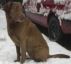

In [20]:
img = data_preprocessing(img_filenames_th[1500][:-6]+'.jpg',0)
img = transform1(img)
img

# Device

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Model

The model below functions as a normal Generative Adversarial Network. It has two parts - the first section generates plausbile data, from the file. The images then become 'negative training exampples' for the other half of the model. The other half learns, through distinguishing the fake data from the real data.

The model below specifically uses the dog data files, as described above, to accomplish this goal. After the code sections below to develop the mdoel, the code chunks highlight the training data edition of testing the model .

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
def conv3x3(in_channel, out_channel): #not change resolusion
    return nn.Conv2d(in_channel,out_channel,
                      kernel_size=3,stride=1,padding=1,dilation=1,bias=False)

def conv1x1(in_channel, out_channel): #not change resolution
    return nn.Conv2d(in_channel,out_channel,
                      kernel_size=1,stride=1,padding=0,dilation=1,bias=False)

def init_weight(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.orthogonal_(m.weight, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
            
    elif classname.find('Batch') != -1:
        m.weight.data.normal_(1,0.02)
        m.bias.data.zero_()
    
    elif classname.find('Linear') != -1:
        nn.init.orthogonal_(m.weight, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    
    elif classname.find('Embedding') != -1:
        nn.init.orthogonal_(m.weight, gain=1)
        

class Attention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.theta    = nn.utils.spectral_norm(conv1x1(channels, channels//8)).apply(init_weight)
        self.phi      = nn.utils.spectral_norm(conv1x1(channels, channels//8)).apply(init_weight)
        self.g        = nn.utils.spectral_norm(conv1x1(channels, channels//2)).apply(init_weight)
        self.o        = nn.utils.spectral_norm(conv1x1(channels//2, channels)).apply(init_weight)
        self.gamma    = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
    def forward(self, inputs):
        batch,c,h,w = inputs.size()
        theta = self.theta(inputs) #->(*,c/8,h,w)
        phi   = F.max_pool2d(self.phi(inputs), [2,2]) #->(*,c/8,h/2,w/2)
        g     = F.max_pool2d(self.g(inputs), [2,2]) #->(*,c/2,h/2,w/2)
        
        theta = theta.view(batch, self.channels//8, -1) #->(*,c/8,h*w)
        phi   = phi.view(batch, self.channels//8, -1) #->(*,c/8,h*w/4)
        g     = g.view(batch, self.channels//2, -1) #->(*,c/2,h*w/4)
        
        beta = F.softmax(torch.bmm(theta.transpose(1,2), phi), -1) #->(*,h*w,h*w/4)
        o    = self.o(torch.bmm(g, beta.transpose(1,2)).view(batch,self.channels//2,h,w)) #->(*,c,h,w)
        return self.gamma*o + inputs
        
    
class ConditionalNorm(nn.Module):
    def __init__(self, in_channel, n_condition):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channel, affine=False) #no learning parameters
        self.embed = nn.Linear(n_condition, in_channel* 2)
        
        nn.init.orthogonal_(self.embed.weight.data[:, :in_channel], gain=1)
        self.embed.weight.data[:, in_channel:].zero_()

    def forward(self, inputs, label):
        out = self.bn(inputs)
        embed = self.embed(label.float())
        gamma, beta = embed.chunk(2, dim=1)
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
        out = gamma * out + beta
        return out

In [25]:
#BigGAN + leaky_relu           
class ResBlock_G(nn.Module):
    def __init__(self, in_channel, out_channel, condition_dim, upsample=True):
        super().__init__()
        self.cbn1 = ConditionalNorm(in_channel, condition_dim)
        self.upsample = nn.Sequential()
        if upsample:
            self.upsample.add_module('upsample',nn.Upsample(scale_factor=2, mode='nearest'))
        self.conv3x3_1 = nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight)
        self.cbn2 = ConditionalNorm(out_channel, condition_dim)
        self.conv3x3_2 = nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight) 
        self.conv1x1   = nn.utils.spectral_norm(conv1x1(in_channel, out_channel)).apply(init_weight)
        
    def forward(self, inputs, condition):
        x  = F.leaky_relu(self.cbn1(inputs, condition))
        x  = self.upsample(x)
        x  = self.conv3x3_1(x)
        x  = self.conv3x3_2(F.leaky_relu(self.cbn2(x, condition)))
        x += self.conv1x1(self.upsample(inputs)) #shortcut
        return x

class Generator(nn.Module):
    def __init__(self, n_feat, codes_dim=24, n_classes=n_classes):
        super().__init__()
        self.fc   = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(codes_dim, 16*n_feat*4*4)).apply(init_weight)
        )
        self.res1 = ResBlock_G(16*n_feat, 16*n_feat, codes_dim+n_classes, upsample=True)
        self.res2 = ResBlock_G(16*n_feat,  8*n_feat, codes_dim+n_classes, upsample=True)
        #self.attn2 = Attention(8*n_feat)
        self.res3 = ResBlock_G( 8*n_feat,  4*n_feat, codes_dim+n_classes, upsample=True)
        self.attn = Attention(4*n_feat)
        self.res4 = ResBlock_G( 4*n_feat,  2*n_feat, codes_dim+n_classes, upsample=True)
        self.conv = nn.Sequential(
            #nn.BatchNorm2d(2*n_feat).apply(init_weight),
            nn.LeakyReLU(),
            nn.utils.spectral_norm(conv3x3(2*n_feat, 3)).apply(init_weight),
        )
        
    def forward(self, z, label_ohe, codes_dim=24):
        '''
        z.shape = (*,120)
        label_ohe.shape = (*,n_classes)
        '''
        batch = z.size(0)
        z = z.squeeze()
        label_ohe = label_ohe.squeeze()
        codes = torch.split(z, codes_dim, dim=1)
        
        x = self.fc(codes[0]) #->(*,16ch*4*4)
        x = x.view(batch,-1,4,4) #->(*,16ch,4,4)
        
        condition = torch.cat([codes[1], label_ohe], dim=1) #(*,codes_dim+n_classes)
        x = self.res1(x, condition)#->(*,16ch,8,8)
        
        condition = torch.cat([codes[2], label_ohe], dim=1)
        x = self.res2(x, condition) #->(*,8ch,16,16)
        #x = self.attn2(x) #not change shape
        
        condition = torch.cat([codes[3], label_ohe], dim=1)
        x = self.res3(x, condition) #->(*,4ch,32,32)
        x = self.attn(x) #not change shape
        
        condition = torch.cat([codes[4], label_ohe], dim=1)
        x = self.res4(x, condition) #->(*,2ch,64,64)
        
        x = self.conv(x) #->(*,3,64,64)
        x = torch.tanh(x)
        return x
    

class ResBlock_D(nn.Module):
    def __init__(self, in_channel, out_channel, downsample=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight),
        )
        self.shortcut = nn.Sequential(
            nn.utils.spectral_norm(conv1x1(in_channel,out_channel)).apply(init_weight),
        )
        if downsample:
            self.layer.add_module('avgpool',nn.AvgPool2d(kernel_size=2,stride=2))
            self.shortcut.add_module('avgpool',nn.AvgPool2d(kernel_size=2,stride=2))
        
    def forward(self, inputs):
        x  = self.layer(inputs)
        x += self.shortcut(inputs)
        return x
    

class Discriminator(nn.Module):
    def __init__(self, n_feat, n_classes=n_classes):
        super().__init__()
        self.res1 = ResBlock_D(3, n_feat, downsample=True)
        self.attn = Attention(n_feat)
        self.res2 = ResBlock_D(  n_feat, 2*n_feat, downsample=True)
        #self.attn2 = Attention(2*n_feat)
        self.res3 = ResBlock_D(2*n_feat, 4*n_feat, downsample=True)
        self.res4 = ResBlock_D(4*n_feat, 8*n_feat, downsample=True)
        self.res5 = ResBlock_D(8*n_feat,16*n_feat, downsample=False)
        self.fc   = nn.utils.spectral_norm(nn.Linear(16*n_feat,1)).apply(init_weight)
        self.embedding = nn.Embedding(num_embeddings=n_classes, embedding_dim=16*n_feat).apply(init_weight)
        
    def forward(self, inputs, label):
        batch = inputs.size(0) #(*,3,64,64)
        h = self.res1(inputs) #->(*,ch,32,32)
        h = self.attn(h) #not change shape
        h = self.res2(h) #->(*,2ch,16,16)
        #h = self.attn2(h) #not change shape
        h = self.res3(h) #->(*,4ch,8,8)
        h = self.res4(h) #->(*,8ch,4,4)
        h = self.res5(h) #->(*,16ch,4,4)
        h = torch.sum((F.leaky_relu(h,0.2)).view(batch,-1,4*4), dim=2) #GlobalSumPool ->(*,16ch)
        outputs = self.fc(h) #->(*,1)
        
        if label is not None:
            embed = self.embedding(label) #->(*,16ch)
            outputs += torch.sum(embed*h,dim=1,keepdim=True) #->(*,1)
        
        outputs = torch.sigmoid(outputs)
        return outputs

# Train

In [27]:
def generate_img(netG,fixed_noise,fixed_aux_labels=None):
    if fixed_aux_labels is not None:
        gen_image = netG(fixed_noise,fixed_aux_labels).to('cpu').clone().detach().squeeze(0)
    else:
        gen_image = netG(fixed_noise).to('cpu').clone().detach().squeeze(0)
    #denormalize
    gen_image = gen_image*0.5 + 0.5
    gen_image_numpy = gen_image.numpy().transpose(0,2,3,1)
    return gen_image_numpy

def show_generate_imgs(netG,fixed_noise,fixed_aux_labels=None):
    gen_images_numpy = generate_img(netG,fixed_noise,fixed_aux_labels)

    fig = plt.figure(figsize=(25, 16))
    # display 10 images from each class
    for i, img in enumerate(gen_images_numpy):
        ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        plt.imshow(img)
    plt.show()
    plt.close()

In [28]:
#https://www.kaggle.com/osciiart/resnet34-mel-ver3-log-multi-hardaug?scriptVersionId=13887036
def cycle(iterable):
    """
    dataloaderをiteratorに変換
    :param iterable:
    :return:
    """
    while True:
        for x in iterable:
            yield x

In [29]:
#BigGAN
def run(lr_G=3e-4,lr_D=3e-4, beta1=0.0, beta2=0.999, nz=120, epochs=2, 
        n_ite_D=1, ema_decay_rate=0.999, show_epoch_list=None, output_freq=10):
#     #G:4M, D:3M params
#     netG = Generator(n_feat=22, codes_dim=24, n_classes=n_classes).to(device) #z.shape=(*,120)
#     netD = Discriminator(n_feat=26, n_classes=n_classes).to(device)
#     #G:6M, D:5M params
#     netG = Generator(n_feat=27, codes_dim=24, n_classes=n_classes).to(device) #z.shape=(*,120)
#     netD = Discriminator(n_feat=33, n_classes=n_classes).to(device)
#     #G:8M, D:7M params
#     netG = Generator(n_feat=32, codes_dim=24, n_classes=n_classes).to(device) #z.shape=(*,120)
#     netD = Discriminator(n_feat=38, n_classes=n_classes).to(device)
    #G:10M, D:8M params
    netG = Generator(n_feat=36, codes_dim=24, n_classes=n_classes).to(device) #z.shape=(*,120)
    netD = Discriminator(n_feat=42, n_classes=n_classes).to(device)
#     #G:14M, D:12M params
#     netG = Generator(n_feat=42, codes_dim=24, n_classes=n_classes).to(device) #z.shape=(*,120)
#     netD = Discriminator(n_feat=50, n_classes=n_classes).to(device)
#     #G:25M, D:22M params
#     netG = Generator(n_feat=56, codes_dim=24, n_classes=n_classes).to(device) #z.shape=(*,120)
#     netD = Discriminator(n_feat=68, n_classes=n_classes).to(device)
#     #G:32M, D:31M params
#     netG = Generator(n_feat=64, codes_dim=24, n_classes=n_classes).to(device) #z.shape=(*,120)
#     netD = Discriminator(n_feat=80, n_classes=n_classes).to(device)

    if EMA:
        #EMA of G for sampling
        netG_EMA = Generator(n_feat=42, codes_dim=24, n_classes=n_classes).to(device)
        netG_EMA.load_state_dict(netG.state_dict())
        for p in netG_EMA.parameters():
            p.requires_grad = False

        
    print(count_parameters(netG))
    print(count_parameters(netD))
    
    real_label = 0.9
    fake_label = 0
    
    D_loss_list = []
    G_loss_list = []
    
    dis_criterion = nn.BCELoss().to(device)

    optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, beta2))
    
    fixed_noise = torch.randn(32, nz, 1, 1, device=device)
    #fixed_noise = fixed_noise / fixed_noise.norm(dim=1, keepdim=True)
    fixed_aux_labels     = np.random.randint(0,n_classes, 32)
    fixed_aux_labels_ohe = np.eye(n_classes)[fixed_aux_labels]
    fixed_aux_labels_ohe = torch.from_numpy(fixed_aux_labels_ohe[:,:,np.newaxis,np.newaxis])
    fixed_aux_labels_ohe = fixed_aux_labels_ohe.float().to(device, non_blocking=True)

    netG.train()
    netD.train()

    ### training here
    for epoch in range(1,epochs+1):
        if elapsed_time(start_time) > TIME_LIMIT:
            print(f'elapsed_time go beyond {TIME_LIMIT} sec')
            break
        D_running_loss = 0
        G_running_loss = 0
        for ii, data in enumerate(train_loader):
            ############################
            # (1) Update D network
            ###########################
            for _ in range(n_ite_D):
                
                if LABEL_NOISE:
                    real_label = 0.9
                    fake_label = 0
                    if np.random.random() < LABEL_NOISE_PROB:
                        real_label = 0
                        fake_label = 0.9
                    
                # train with real
                netD.zero_grad()
                real_images = data['img'].to(device, non_blocking=True) 
                batch_size  = real_images.size(0)
                dis_labels  = torch.full((batch_size, 1), real_label, device=device) #shape=(*,)
                aux_labels  = data['label'].long().to(device, non_blocking=True) #shape=(*,)
                dis_output = netD(real_images, aux_labels) #dis shape=(*,1)
                errD_real  = dis_criterion(dis_output, dis_labels)
                errD_real.backward(retain_graph=True)

                # train with fake
                noise  = torch.randn(batch_size, nz, 1, 1, device=device)
                #noise = noise / noise.norm(dim=1, keepdim=True)
                aux_labels     = np.random.randint(0,n_classes, batch_size)
                aux_labels_ohe = np.eye(n_classes)[aux_labels]
                aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:,:,np.newaxis,np.newaxis])
                aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
                aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)
                
                fake = netG(noise, aux_labels_ohe) #output shape=(*,3,64,64)
                dis_labels.fill_(fake_label)
                dis_output = netD(fake.detach(),aux_labels)
                errD_fake  = dis_criterion(dis_output, dis_labels)
                errD_fake.backward(retain_graph=True)
                D_running_loss += (errD_real.item() + errD_fake.item())/len(train_loader)
                optimizerD.step()

            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            dis_labels.fill_(real_label)  # fake labels are real for generator cost
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            aux_labels     = np.random.randint(0,n_classes, batch_size)
            aux_labels_ohe = np.eye(n_classes)[aux_labels]
            aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:,:,np.newaxis,np.newaxis])
            aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
            aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)
            fake  = netG(noise, aux_labels_ohe)
            
            dis_output = netD(fake, aux_labels)
            errG   = dis_criterion(dis_output, dis_labels)
            errG.backward(retain_graph=True)
            G_running_loss += errG.item()/len(train_loader)
            optimizerG.step()
        
        if EMA:
            #update netG_EMA
            param_itr = cycle(netG.parameters())
            for i,p_EMA in enumerate(netG_EMA.parameters()):
                p = next(param_itr)
                p_EMA.data = (1-ema_decay_rate)*p_EMA.data + ema_decay_rate*p.data
                p_EMA.requires_grad = False
        
        #log
        D_loss_list.append(D_running_loss)
        G_loss_list.append(G_running_loss)
        
        #output
        if epoch % output_freq == 0:
            print('[{:d}/{:d}] D_loss = {:.3f}, G_loss = {:.3f}, elapsed_time = {:.1f} min'.format(epoch,epochs,D_running_loss,G_running_loss,elapsed_time(start_time)/60))
            
        if epoch in show_epoch_list:
            print('epoch = {}'.format(epoch))
            if not EMA:
                show_generate_imgs(netG,fixed_noise,fixed_aux_labels_ohe)
            elif EMA:
                show_generate_imgs(netG_EMA,fixed_noise,fixed_aux_labels_ohe)
            
        if epoch % 100 == 0:
            if not EMA:
                torch.save(netG.state_dict(), f'generator_epoch{epoch}.pth')
            elif EMA:
                torch.save(netG_EMA.state_dict(), f'generator_epoch{epoch}.pth')
    
    if not EMA:
        torch.save(netG.state_dict(), 'generator.pth')
    elif EMA:
        torch.save(netG_EMA.state_dict(), 'generator.pth')
    torch.save(netD.state_dict(), 'discriminator.pth')
    
    res = {'netG':netG,
           'netD':netD,
           'nz':nz,
           'fixed_noise':fixed_noise,
           'fixed_aux_labels_ohe':fixed_aux_labels_ohe,
           'D_loss_list':D_loss_list,
           'G_loss_list':G_loss_list,
          }
    if EMA:
        res['netG_EMA'] = netG_EMA
        
    return res

10491625
8497274
epoch = 1


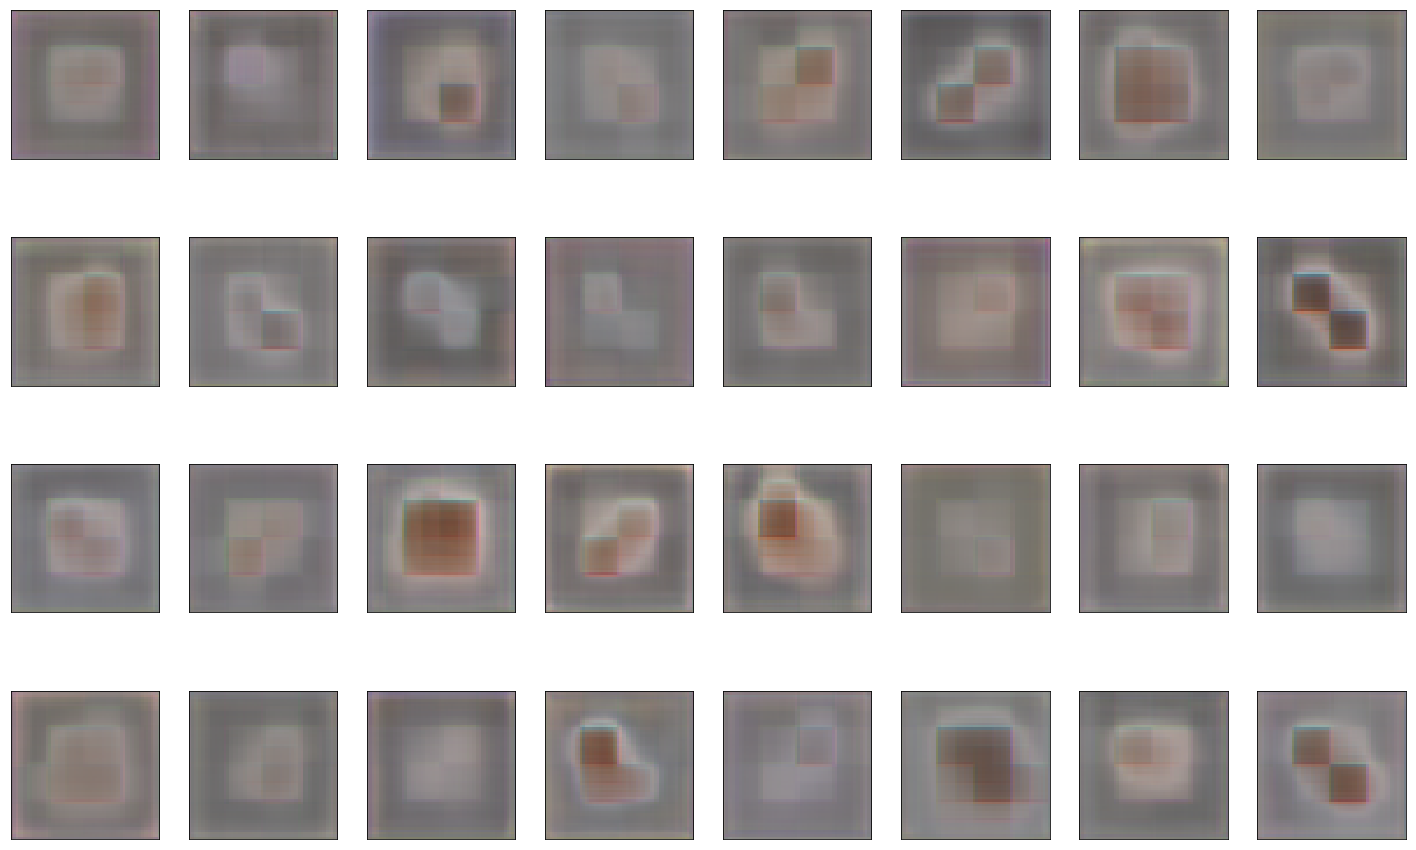

epoch = 2


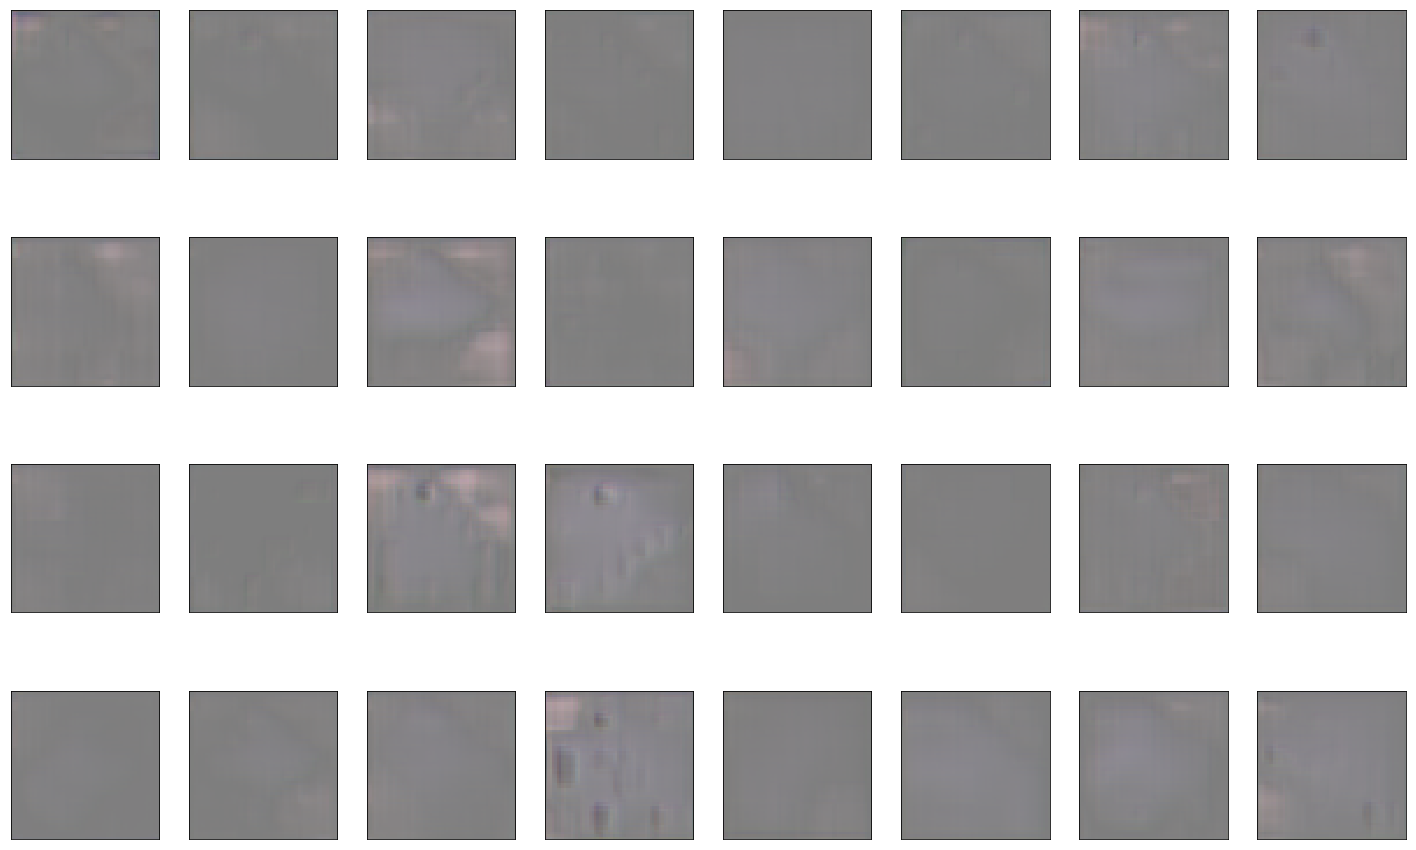

epoch = 3


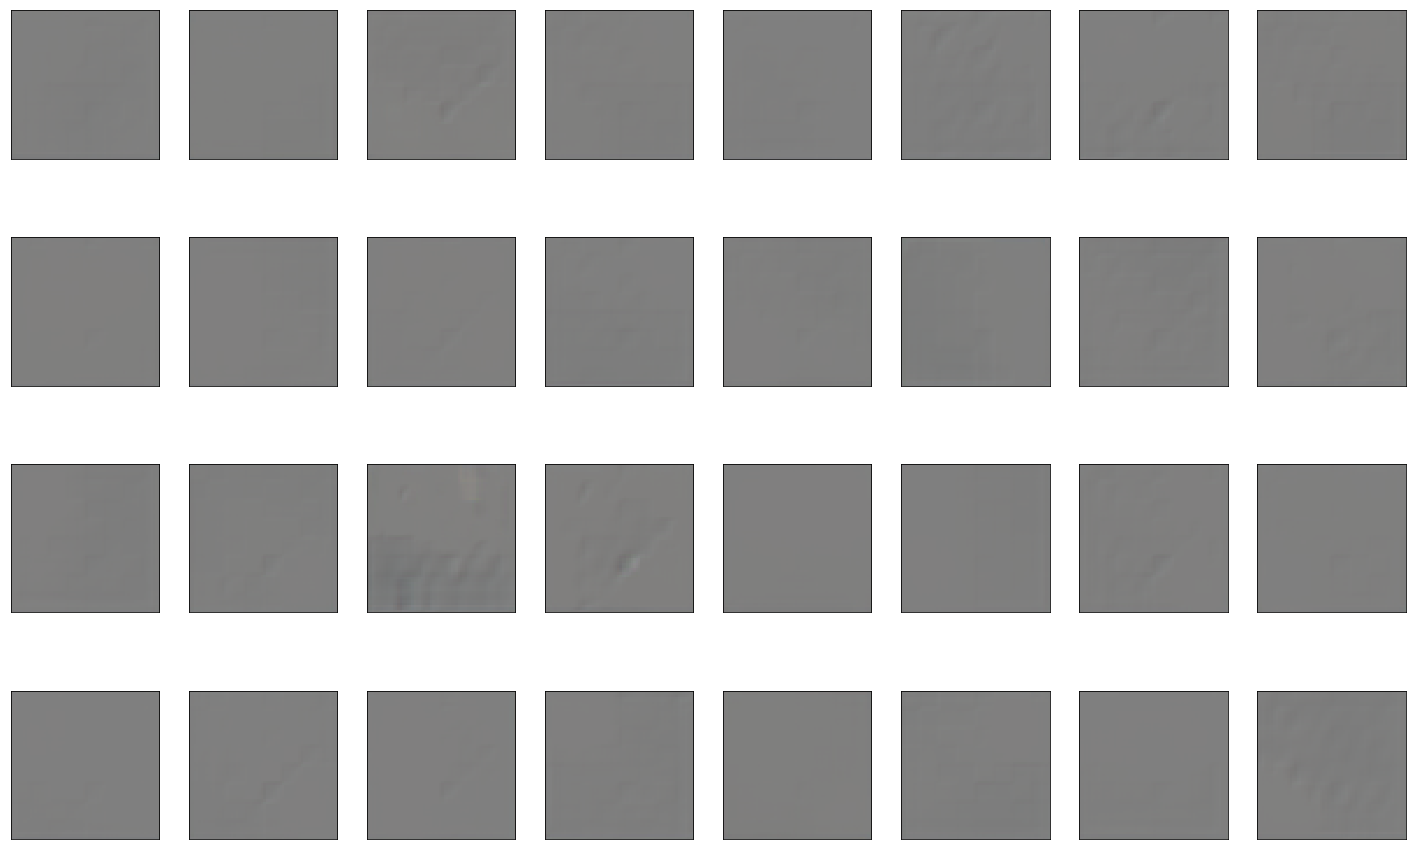

KeyboardInterrupt: 

In [30]:
%%time
#show_epoch_list = np.arange(0,100,1)
show_epoch_list = np.arange(0,500+10,1)

res = run(lr_G=3e-4,lr_D=3e-4, beta1=0.0, beta2=0.999, nz=120, epochs=500, 
          n_ite_D=1, ema_decay_rate=None, show_epoch_list=show_epoch_list, output_freq=5)
# res = run(lr_G=3e-4,lr_D=3e-4, beta1=0.5, beta2=0.999, nz=120, epochs=500, 
#           n_ite_D=1, ema_decay_rate=None, show_epoch_list=show_epoch_list, output_freq=10)

In [31]:
plt.plot(res['D_loss_list'], label='D_loss')
plt.plot(res['G_loss_list'], label='G_loss')
plt.grid()
plt.legend()
plt.title('loss history');

NameError: name 'res' is not defined

**Results & Conclusion**

Overall, this model outputted a file that would have placed in the top 100 on the Kaggle assignment board. There were definite opportunities to improve, however, believe that it did well considering the circumstances..

As for my concluding thoughts, I am planning to implament a GAN model into some data that I currently work with. I'm hoping through the data images, I can help predict and classifying what images track to different patterns. This assignment did a great job in helping me continue to learn and grow as a data scientist. 